In [2]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [3]:
def load_photos(directory):
    images = []
    labels_speed = []
    labels_dir = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(96, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value_dir = float(name.split('_')[1])
        value_speed = float(name.split('_')[0])
        labels_dir.append(value_dir)
        labels_speed.append(value_speed)
        images.append(image)
    return images, labels_speed, labels_dir

In [4]:
dataset = "BigOne_Race_5"

In [5]:
# load images from both train and test groups
directory = dataset+'/Train'
images, labels_speed, labels_dir = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels for training: %d' % nb_images)

Loaded Images and labels for training: 7953


In [6]:
#Normalise images
images = np.array(images)
images /= 255.0

In [7]:
#convert datas to dummyvalues
labels_speed = np.array(pd.get_dummies(labels_speed))
labels_dir = np.array(pd.get_dummies(labels_dir))

(array([1, 0], dtype=uint8),
 array([0, 0, 0, 1, 0], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7fcbce465be0>)

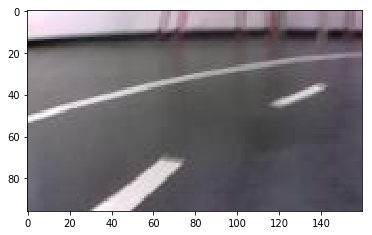

In [8]:
labels_speed[42], labels_dir[42], plt.imshow(images[42])

In [9]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers
import keras.callbacks

In [10]:
#from keras.models import load_model
#model = load_model("model_bigrace_original_5.h5")

In [21]:
'''
Model from PatateV2
'''

K.clear_session()
############################################################# 

img_in = Input(shape=(96, 160, 3), name='img_in')
x = img_in

x = Convolution2D(2, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Convolution2D(4, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Convolution2D(8, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Flatten(name='flattened')(x)

x = Dropout(.5)(x)
x = Dense(100, use_bias=False)(x) 
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.4)(x)
x = Dense(50, use_bias=False)(x)  
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.3)(x)

# Multitask Output
out_speed = Dense(10, use_bias=False)(x)  
out_speed = BatchNormalization()(out_speed)
out_speed = Activation("relu")(out_speed)
out_speed = Dropout(.2)(out_speed)
out_speed = Dense(2, activation='softmax')(out_speed)

out_dir = Dense(10, use_bias=False)(x)  
out_dir = BatchNormalization()(out_dir)
out_dir = Activation("relu")(out_dir)
out_dir = Dropout(.2)(out_dir)
out_dir = Dense(5, activation='softmax')(out_dir)


# Compile Model
model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 96, 160, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 78, 2)    150         img_in[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 78, 2)    8           conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 46, 78, 2)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [22]:
model_name="model_bigrace_original_5.h5"

In [23]:
#save best model if model improved
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
h = model.fit(images, [labels_speed, labels_dir], batch_size=64, epochs=100, validation_split=0.2, verbose=1, callbacks=[best_checkpoint])

Train on 6362 samples, validate on 1591 samples
Epoch 1/100
6362/6362 [==============================] - 7s 1ms/step - loss: 2.2801 - dense_4_loss: 0.5621 - dense_6_loss: 1.7180 - dense_4_acc: 0.7287 - dense_6_acc: 0.2517 - val_loss: 2.5408 - val_dense_4_loss: 0.7207 - val_dense_6_loss: 1.8201 - val_dense_4_acc: 0.7511 - val_dense_6_acc: 0.2722

Epoch 00001: val_loss improved from inf to 2.54076, saving model to model_bigrace_original_5.h5
Epoch 2/100
6362/6362 [==============================] - 4s 653us/step - loss: 2.0145 - dense_4_loss: 0.4897 - dense_6_loss: 1.5248 - dense_4_acc: 0.7680 - dense_6_acc: 0.3489 - val_loss: 8.1447 - val_dense_4_loss: 3.2441 - val_dense_6_loss: 4.9006 - val_dense_4_acc: 0.7511 - val_dense_6_acc: 0.1540

Epoch 00002: val_loss did not improve
Epoch 3/100
6362/6362 [==============================] - 4s 657us/step - loss: 1.8634 - dense_4_loss: 0.4413 - dense_6_loss: 1.4222 - dense_4_acc: 0.7680 - dense_6_acc: 0.4057 - val_loss: 1.6612 - val_dense_4_loss: 0

6362/6362 [==============================] - 4s 671us/step - loss: 0.8787 - dense_4_loss: 0.2163 - dense_6_loss: 0.6624 - dense_4_acc: 0.9109 - dense_6_acc: 0.7619 - val_loss: 0.6745 - val_dense_4_loss: 0.2057 - val_dense_6_loss: 0.4688 - val_dense_4_acc: 0.9139 - val_dense_6_acc: 0.8353

Epoch 00023: val_loss improved from 0.76481 to 0.67446, saving model to model_bigrace_original_5.h5
Epoch 24/100
6362/6362 [==============================] - 4s 652us/step - loss: 0.8760 - dense_4_loss: 0.2212 - dense_6_loss: 0.6548 - dense_4_acc: 0.9131 - dense_6_acc: 0.7697 - val_loss: 0.6700 - val_dense_4_loss: 0.2115 - val_dense_6_loss: 0.4585 - val_dense_4_acc: 0.9045 - val_dense_6_acc: 0.8460

Epoch 00024: val_loss improved from 0.67446 to 0.66995, saving model to model_bigrace_original_5.h5
Epoch 25/100
6362/6362 [==============================] - 4s 649us/step - loss: 0.8527 - dense_4_loss: 0.2102 - dense_6_loss: 0.6425 - dense_4_acc: 0.9156 - dense_6_acc: 0.7768 - val_loss: 0.6314 - val_dense


Epoch 00045: val_loss did not improve
Epoch 46/100
6362/6362 [==============================] - 4s 660us/step - loss: 0.6667 - dense_4_loss: 0.1863 - dense_6_loss: 0.4804 - dense_4_acc: 0.9253 - dense_6_acc: 0.8433 - val_loss: 0.5625 - val_dense_4_loss: 0.1899 - val_dense_6_loss: 0.3725 - val_dense_4_acc: 0.9195 - val_dense_6_acc: 0.8793

Epoch 00046: val_loss did not improve
Epoch 47/100
6362/6362 [==============================] - 4s 664us/step - loss: 0.6685 - dense_4_loss: 0.1835 - dense_6_loss: 0.4850 - dense_4_acc: 0.9249 - dense_6_acc: 0.8354 - val_loss: 0.4926 - val_dense_4_loss: 0.1719 - val_dense_6_loss: 0.3207 - val_dense_4_acc: 0.9315 - val_dense_6_acc: 0.8988

Epoch 00047: val_loss improved from 0.54766 to 0.49257, saving model to model_bigrace_original_5.h5
Epoch 48/100
6362/6362 [==============================] - 4s 645us/step - loss: 0.6659 - dense_4_loss: 0.1825 - dense_6_loss: 0.4835 - dense_4_acc: 0.9304 - dense_6_acc: 0.8354 - val_loss: 0.5043 - val_dense_4_loss: 0

6362/6362 [==============================] - 4s 669us/step - loss: 0.5511 - dense_4_loss: 0.1606 - dense_6_loss: 0.3905 - dense_4_acc: 0.9351 - dense_6_acc: 0.8713 - val_loss: 0.5857 - val_dense_4_loss: 0.2007 - val_dense_6_loss: 0.3850 - val_dense_4_acc: 0.9170 - val_dense_6_acc: 0.8781

Epoch 00069: val_loss did not improve
Epoch 70/100
6362/6362 [==============================] - 4s 649us/step - loss: 0.5735 - dense_4_loss: 0.1722 - dense_6_loss: 0.4014 - dense_4_acc: 0.9340 - dense_6_acc: 0.8631 - val_loss: 0.4465 - val_dense_4_loss: 0.1659 - val_dense_6_loss: 0.2806 - val_dense_4_acc: 0.9390 - val_dense_6_acc: 0.9170

Epoch 00070: val_loss did not improve
Epoch 71/100
6362/6362 [==============================] - 4s 654us/step - loss: 0.5794 - dense_4_loss: 0.1696 - dense_6_loss: 0.4099 - dense_4_acc: 0.9315 - dense_6_acc: 0.8662 - val_loss: 0.5097 - val_dense_4_loss: 0.1774 - val_dense_6_loss: 0.3324 - val_dense_4_acc: 0.9277 - val_dense_6_acc: 0.8875

Epoch 00071: val_loss did no

In [ ]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))